# Fraud detection 

The notebook is for understanding the dataset, exploring, processing and building a prediction model for predicting fraud events

1. What is the model's Precision and Accuracy?
1. How Reliable is the model in classifying transactions as legitimate or fraudulent?


# 0.0 Imports and Helper Functions

## 0.1 Imports

In [119]:
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML 

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV


## 0.2 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [181]:
def jupyter_settings():
    %matplotlib inline

    
    sns.set(font_scale=1.6)
    
    # Set the style
    sns.set_style("darkgrid")

    
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

In [4]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [5]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [6]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [7]:
## Labels dataset
df_labels = pd.read_csv('data-new/labels_obf.csv')
df_labels.head()

,reportedTime,eventId
0,2017-01-04T00:00:00Z,101536329A1
1,2017-01-04T00:00:00Z,101536425A1
2,2017-01-04T00:00:00Z,101536473A1
3,2017-01-04T00:00:00Z,101536617A1
4,2017-01-04T00:00:00Z,101536761A1


In [8]:
## Number of rows in labels - the number of fraud events
print('The number of fraud events:', df_labels.shape[0])

The number of fraud events: 875


In [9]:
## Transactions dataset 
df_transactions = pd.read_csv('data-new/transactions_obf.csv')
df_transactions.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500


In [10]:
## Number of transactions
print('The number of transactions:', df_transactions.shape[0])

The number of transactions: 118621


In [11]:
## Combine labels and transaction data according to eventId

df_labels["isFraud"] = 1

df = pd.merge(df_transactions, df_labels, on = ["eventId"], how='left')
df['isFraud'] = df['isFraud'].fillna(0)

In [12]:
df.head()

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,isFraud
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,NaN,0.0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,NaN,0.0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaN,0.0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,NaN,0.0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,NaN,0.0


## 1.2 Columns

### 1.2.1 Column Descriptions

In [13]:
# Data dictionary
df_dic = pd.read_excel("data-dictionary.xlsx")
df_dic

,Unnamed: 0,Unnamed: 1
0,transactionTime,The time the transaction was requested.
1,eventId,A unique identifying string for this transaction
2,accountNumber,The account number which makes the transaction
3,merchantId,A unique identifying string for this merchant
4,mcc,The merchant category code of the merchant
5,transactionAmount,The value of the transaction in GBP
6,posEntryMode,The Point Of Sale entry mode
7,availableCash,The (rounded) amount available to spend prior ...
8,merchantCountry,A unique identifying string for the merchant's...
9,merchantZip,A truncated zip code for the merchant's postal...


### 1.2.2 Column Rename

In [14]:
cols_old = df.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df.columns = cols_new

In [15]:
df.columns

Index(['transaction_time', 'event_id', 'account_number', 'merchant_id', 'mcc',
       'merchant_country', 'merchant_zip', 'pos_entry_mode',
       'transaction_amount', 'available_cash', 'reported_time', 'is_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [16]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))

Number of Rows: 118621
Number of Cols: 12


## 1.4 Data Types and Structure

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118621 entries, 0 to 118620
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_time    118621 non-null  object 
 1   event_id            118621 non-null  object 
 2   account_number      118621 non-null  object 
 3   merchant_id         118621 non-null  object 
 4   mcc                 118621 non-null  int64  
 5   merchant_country    118621 non-null  int64  
 6   merchant_zip        95616 non-null   object 
 7   pos_entry_mode      118621 non-null  int64  
 8   transaction_amount  118621 non-null  float64
 9   available_cash      118621 non-null  int64  
 10  reported_time       875 non-null     object 
 11  is_fraud            118621 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 10.9+ MB


In [18]:
# change mcc, merchant_country, pos_entry_mode to object instead of int64
columns_to_convert = ['mcc', 'merchant_country', 'pos_entry_mode']  # Replace with your column names

# Change the data type of specified columns to object
df[columns_to_convert] = df[columns_to_convert].astype('object')

## 1.5 Check NA

In [19]:
df.isna().mean()

transaction_time      0.000000
event_id              0.000000
account_number        0.000000
merchant_id           0.000000
mcc                   0.000000
merchant_country      0.000000
merchant_zip          0.193937
pos_entry_mode        0.000000
transaction_amount    0.000000
available_cash        0.000000
reported_time         0.992624
is_fraud              0.000000
dtype: float64

## 1.6 Fill Out NA

In [20]:
# NA in reported_time means no fraud reported - this will not be used in making predictions
# NA in merchant_zip should be filled depending on if I want to use it as a predictor or not - let's have a look first

In [21]:
# Check the rows with merchant_zip with NA 
df.loc[df["merchant_zip"].isna()].head()

,transaction_time,event_id,account_number,merchant_id,mcc,merchant_country,merchant_zip,pos_entry_mode,transaction_amount,available_cash,reported_time,is_fraud
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,NaN,0.0
5,2017-01-01T01:33:23Z,87747828A1,0cc51b98,6b32dc,5968,442,NaN,1,5.94,8500,NaN,0.0
8,2017-01-01T02:24:10Z,73437030A1,d3a5049c,f24576,5999,442,NaN,1,5.93,500,NaN,0.0
11,2017-01-01T03:44:02Z,28051252A1,239f4392,195b34,5499,392,NaN,90,5.61,7500,NaN,0.0
14,2017-01-01T03:53:34Z,85602730A1,645c318d,66f14e,5541,36,NaN,5,10.95,1500,2017-01-14T00:00:00Z,1.0


In [22]:
df.loc[df["merchant_zip"].isna()].shape

(23005, 12)

In [23]:
# df.merchant_zip.value_counts() 

In [24]:
# 0 does not seem to be a valid zip code, and there are too many zip code with only a few transaction
# It would be nice if we can merge the zip code according to the larger areas, but I do not know how atm
# Too many values, I decided not to use it and use country instead

## 1.7 Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [25]:
df['is_fraud'] = df['is_fraud'].map({1: 'yes', 0: 'no'})


## 1.8 Description Statistics

In [26]:
num_attributes = df.select_dtypes(exclude='object')
cat_attributes = df.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [27]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
transaction_amount,118621.0,53.674774,183.665315,-0.15,8.03,20.25,49.0,13348.0,13348.15,3.421818,28.405271,1503.445956
available_cash,118621.0,6625.508974,3410.289486,500.00,4500.00,7500.00,8500.0,18500.0,18000.00,0.514721,-0.182784,-0.541319


* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* transaction_amount is high shap and right skewed.

* Minus amount indicates transfer in rather than out?

* A negative skewness (smaller than 0) indicates that the distribution is skewed to the left, meaning the left tail is longer or fatter than the right tail. In other words, the mass of the distribution is concentrated on the right side, and there are some smaller values on the left side with a few extremely small values.

* A negative kurtosis (smaller than 0) suggests that the distribution is platykurtic, meaning it is flatter and has lighter tails than the normal distribution. This indicates that the distribution has fewer and less extreme outliers than a normal distribution.

### 1.8.2 Categorical Attributes

In [28]:
cat_attributes.describe()

,transaction_time,event_id,account_number,merchant_id,mcc,merchant_country,merchant_zip,pos_entry_mode,reported_time,is_fraud
count,118621,118621,118621,118621,118621,118621,95616,118621,875,118621
unique,118105,118621,766,33327,361,82,3260,10,145,2
top,2017-01-11T05:31:24Z,18688431A1,66b2f8b3,96878e,5411,826,0,5,2017-06-25T00:00:00Z,no
freq,3,1,1312,3294,23937,95616,14474,70228,101,117746


* There's a lot of variability in merchant_id, MCC, merchant_country, merchant_zip, so it could be hard to use one hot encoding.


# 2.0 Selecting Columns

## 2.1 Selecting Columns

I'll use all the columns for data analysis

## 2.2 Selecting Lines

I'll use all the lines.

# 3.0 Exploratory Data Analisys

In [29]:
df1 = df.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response Variable

In [30]:
df1["is_fraud"].value_counts()

is_fraud
no     117746
yes       875
Name: count, dtype: int64

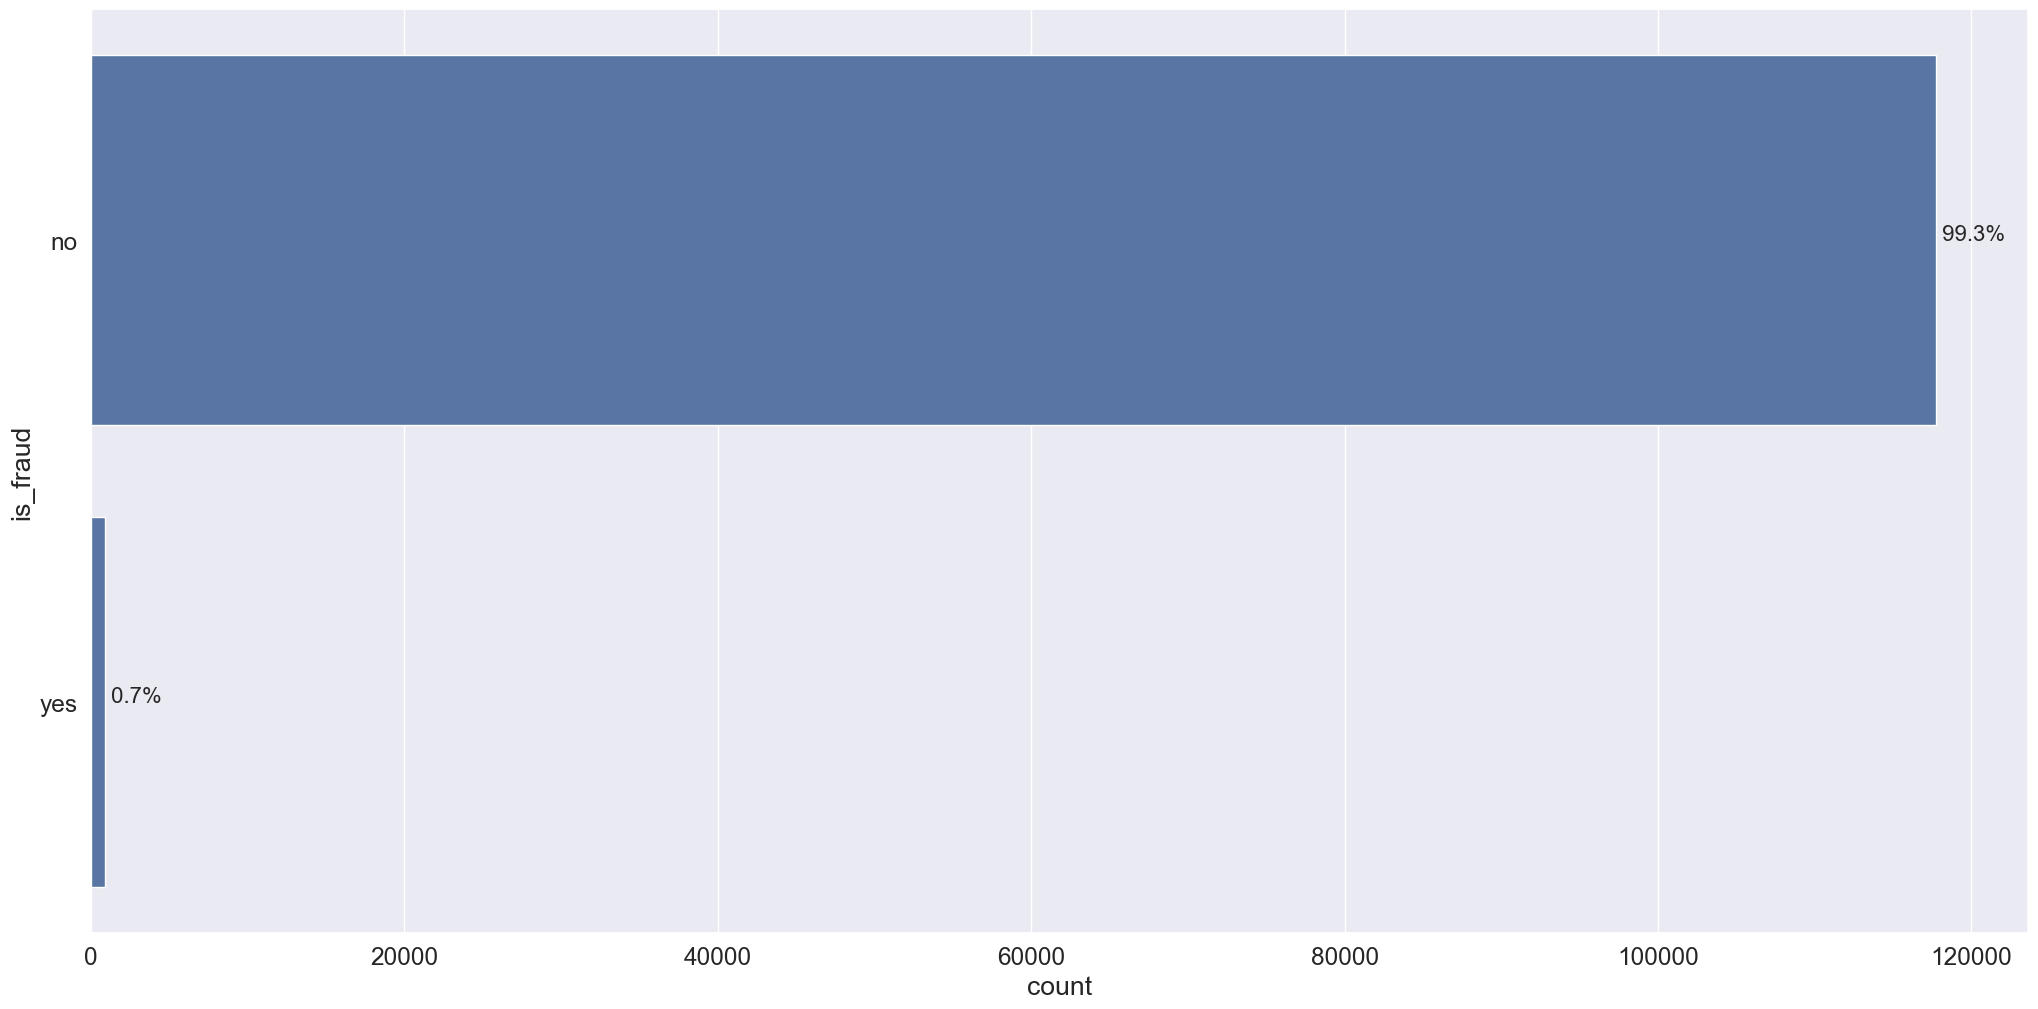

In [31]:
ax = sns.countplot(y='is_fraud', data=df1);

total = df1['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 3.1.2 Numerical Variables

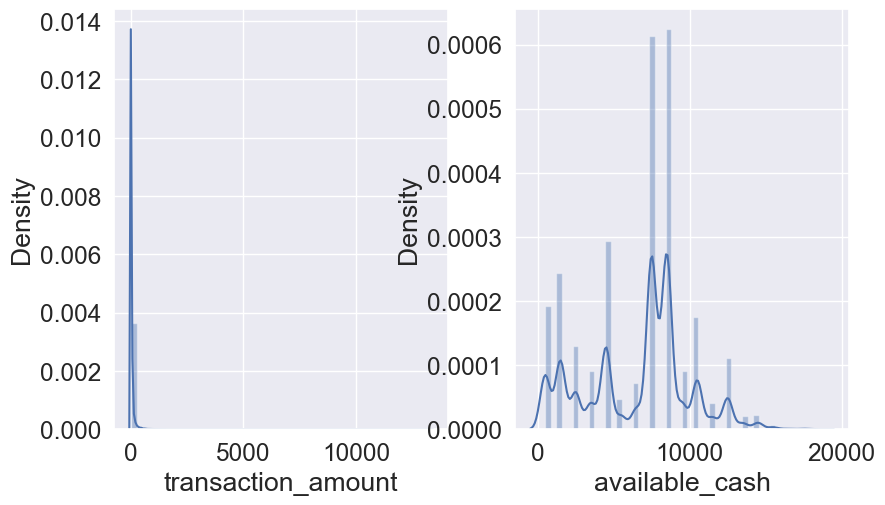

In [32]:
num_attributes = df1.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);
    
    j += 1

### 3.1.3 Categorical Variables

In [33]:
cat_attributes = df1.select_dtypes(include='object').drop(["account_number","transaction_time","reported_time","event_id","merchant_id"],axis=1)


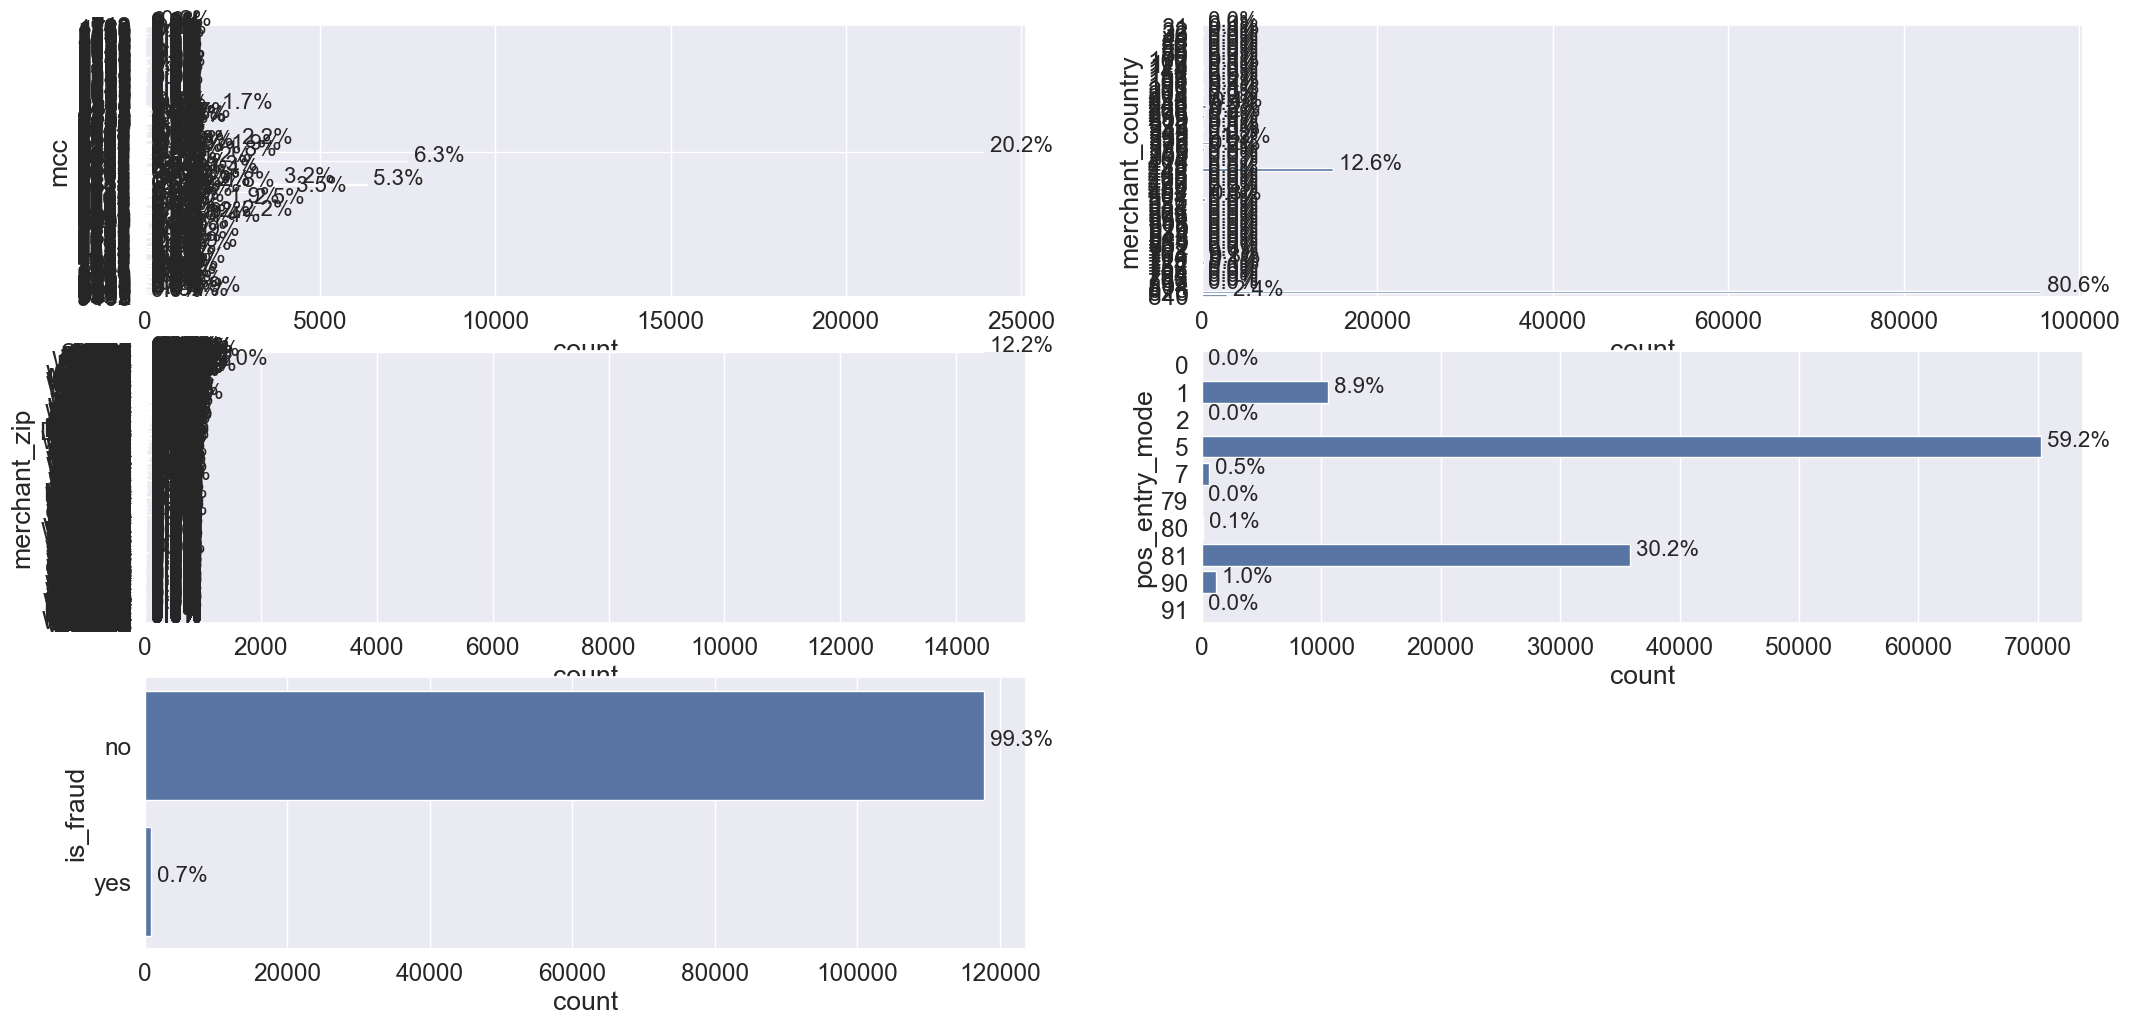

In [34]:

columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

## 3.2 Bivariate Analysis

### The majority fraud transiction occours for the same users.


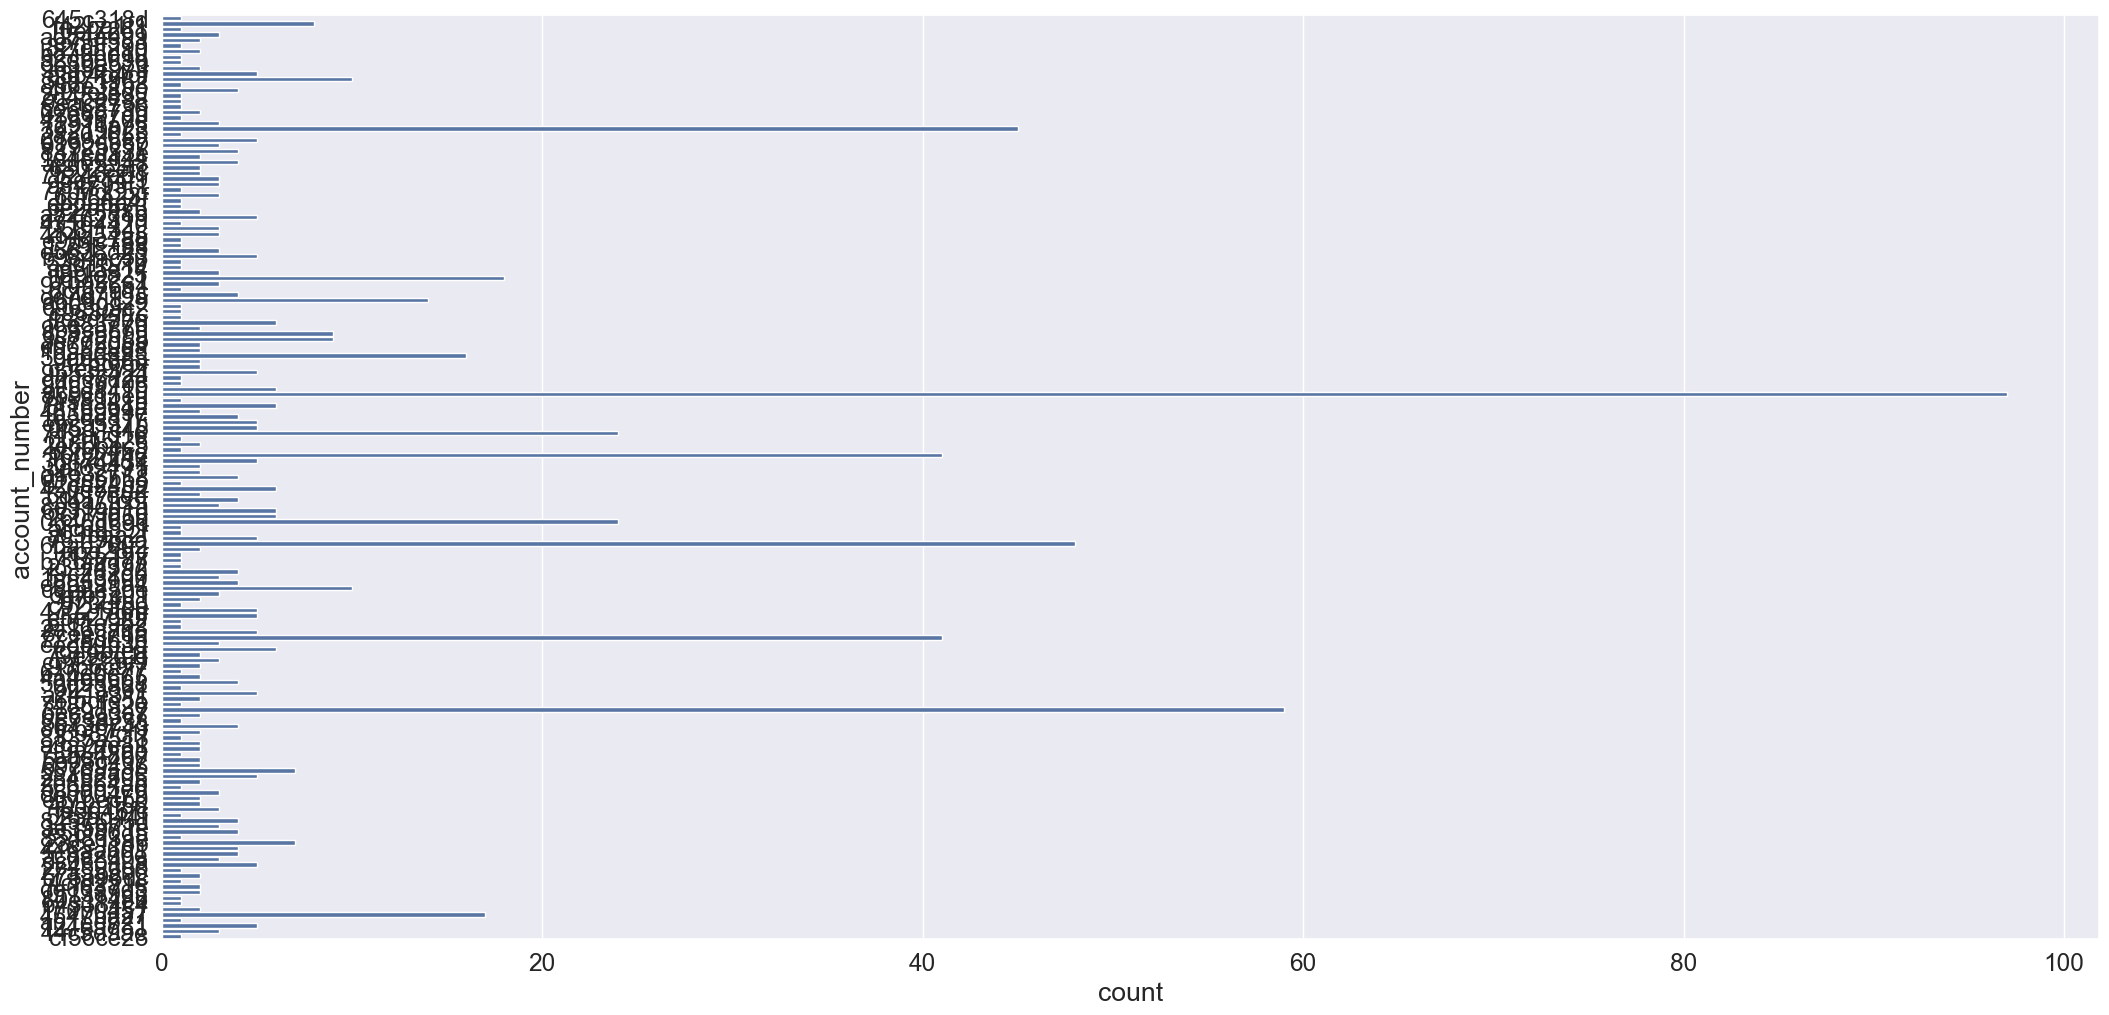

In [36]:
aux1 = df1[df1['is_fraud'] == 'yes']
sns.countplot(y='account_number', data=aux1);

### All the fraud amount is greater than 90.

**TRUE:** The values are greater than 90 and it is bigger than no fraud transactions

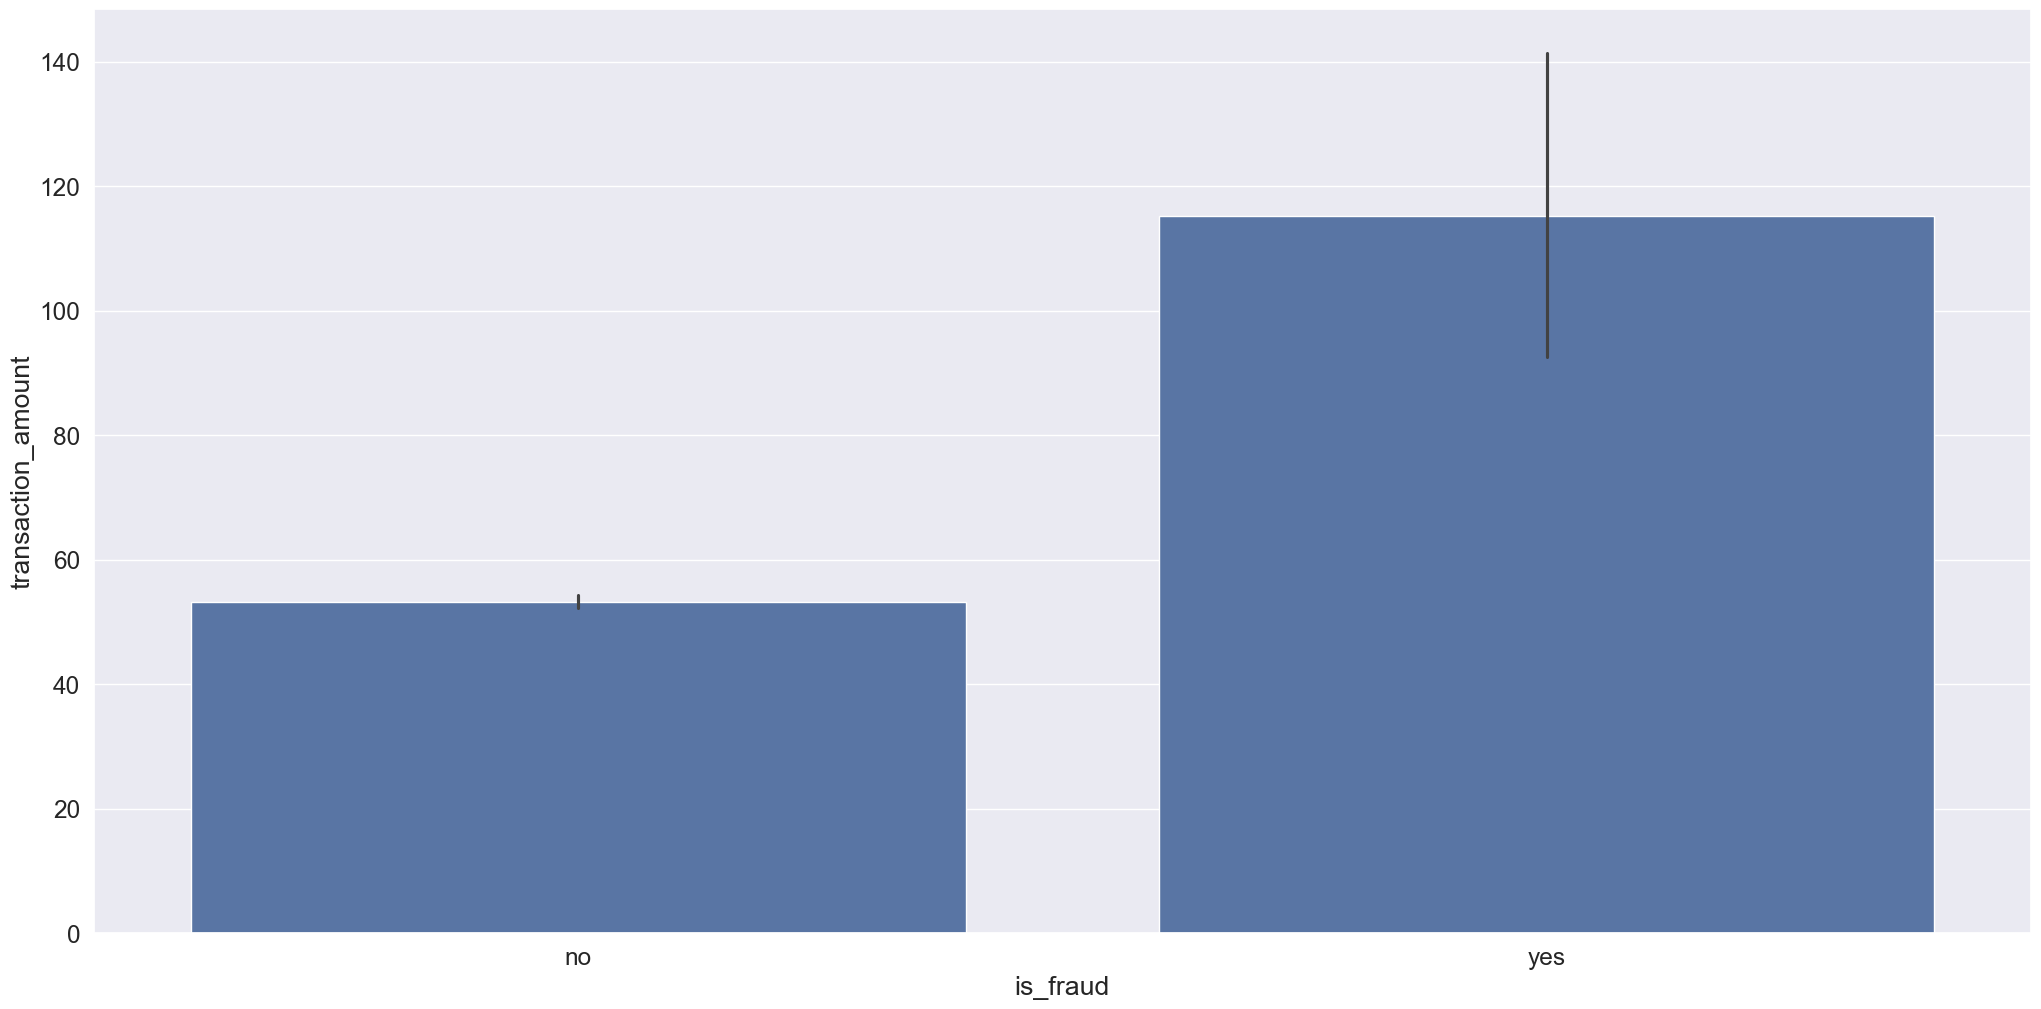

In [37]:
sns.barplot(y='transaction_amount', x='is_fraud', data=df1);

In [38]:
df1.columns

Index(['transaction_time', 'event_id', 'account_number', 'merchant_id', 'mcc',
       'merchant_country', 'merchant_zip', 'pos_entry_mode',
       'transaction_amount', 'available_cash', 'reported_time', 'is_fraud'],
      dtype='object')

### Most fraud transaction occours using within 3 countries.



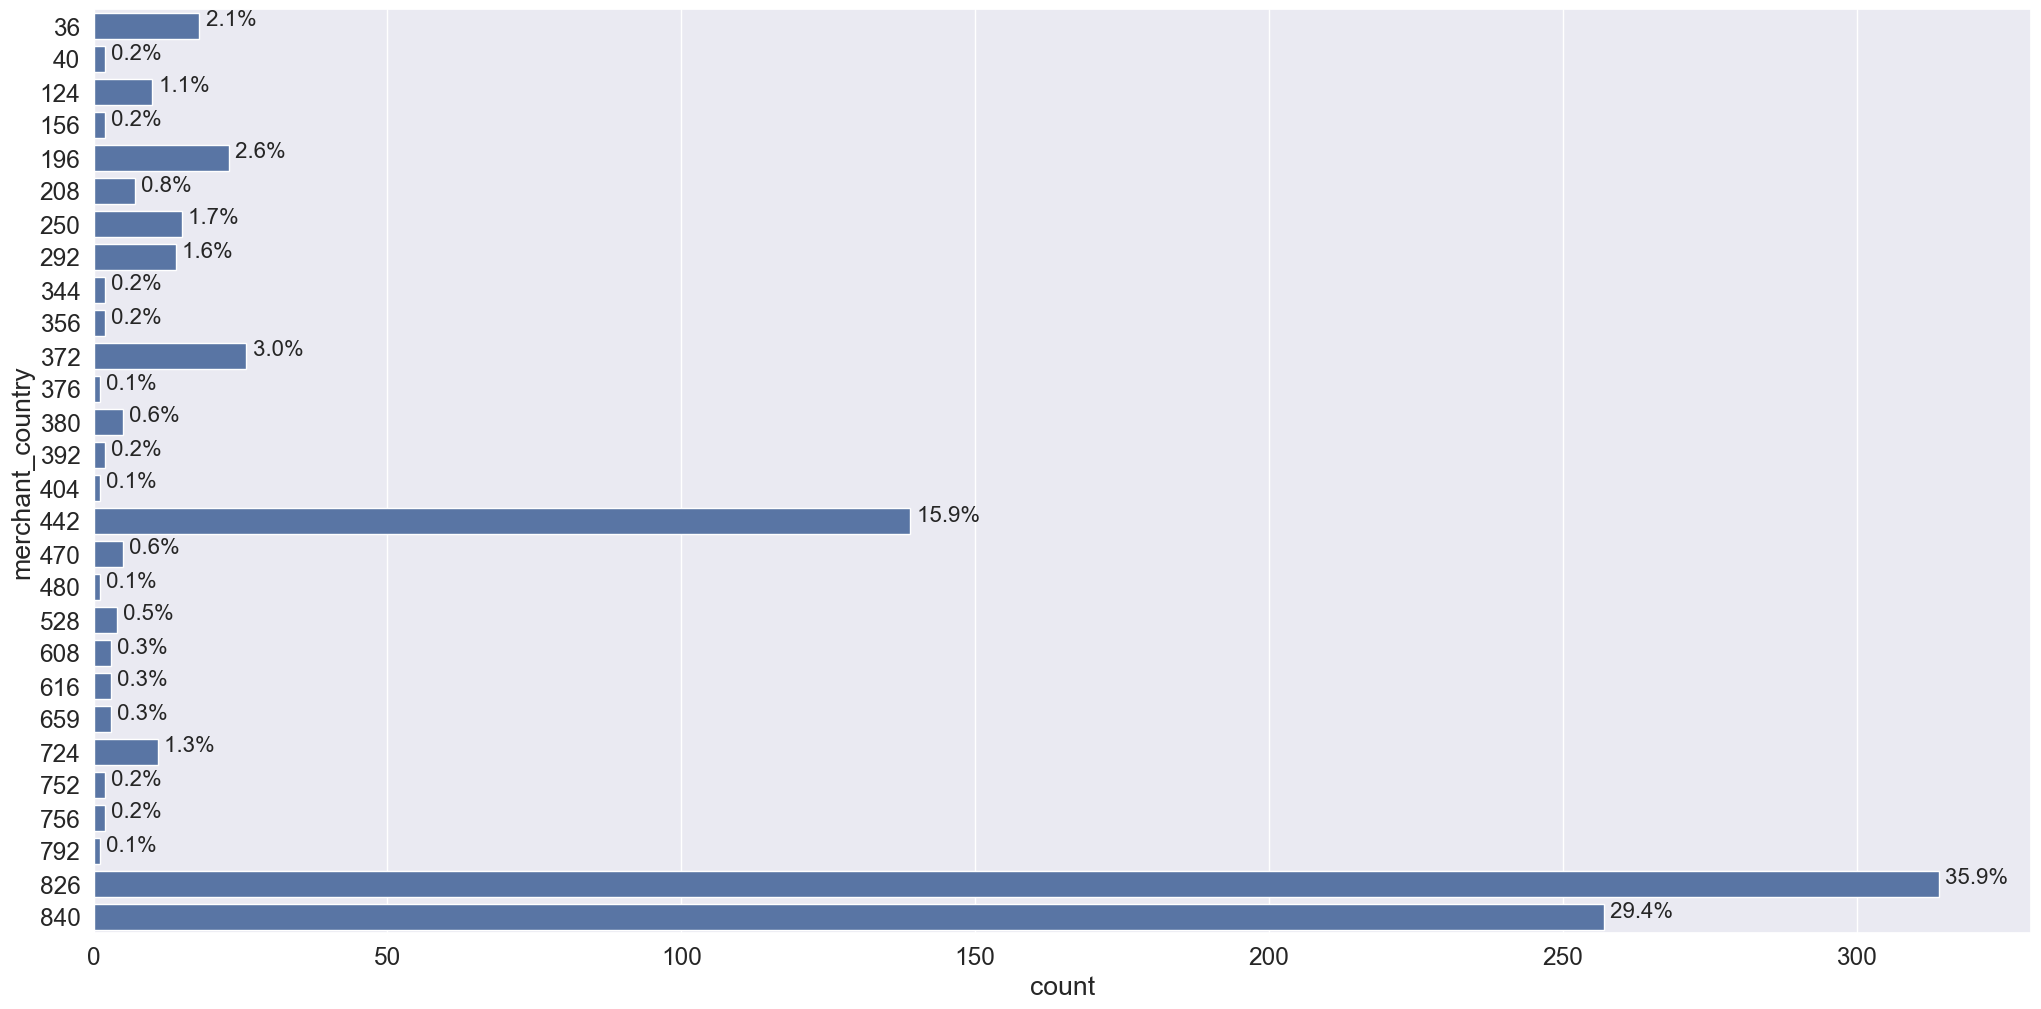

In [39]:
aux1 = df1[df1['is_fraud'] == 'yes']
ax = sns.countplot(y='merchant_country', data=aux1)

total = aux1['merchant_country'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

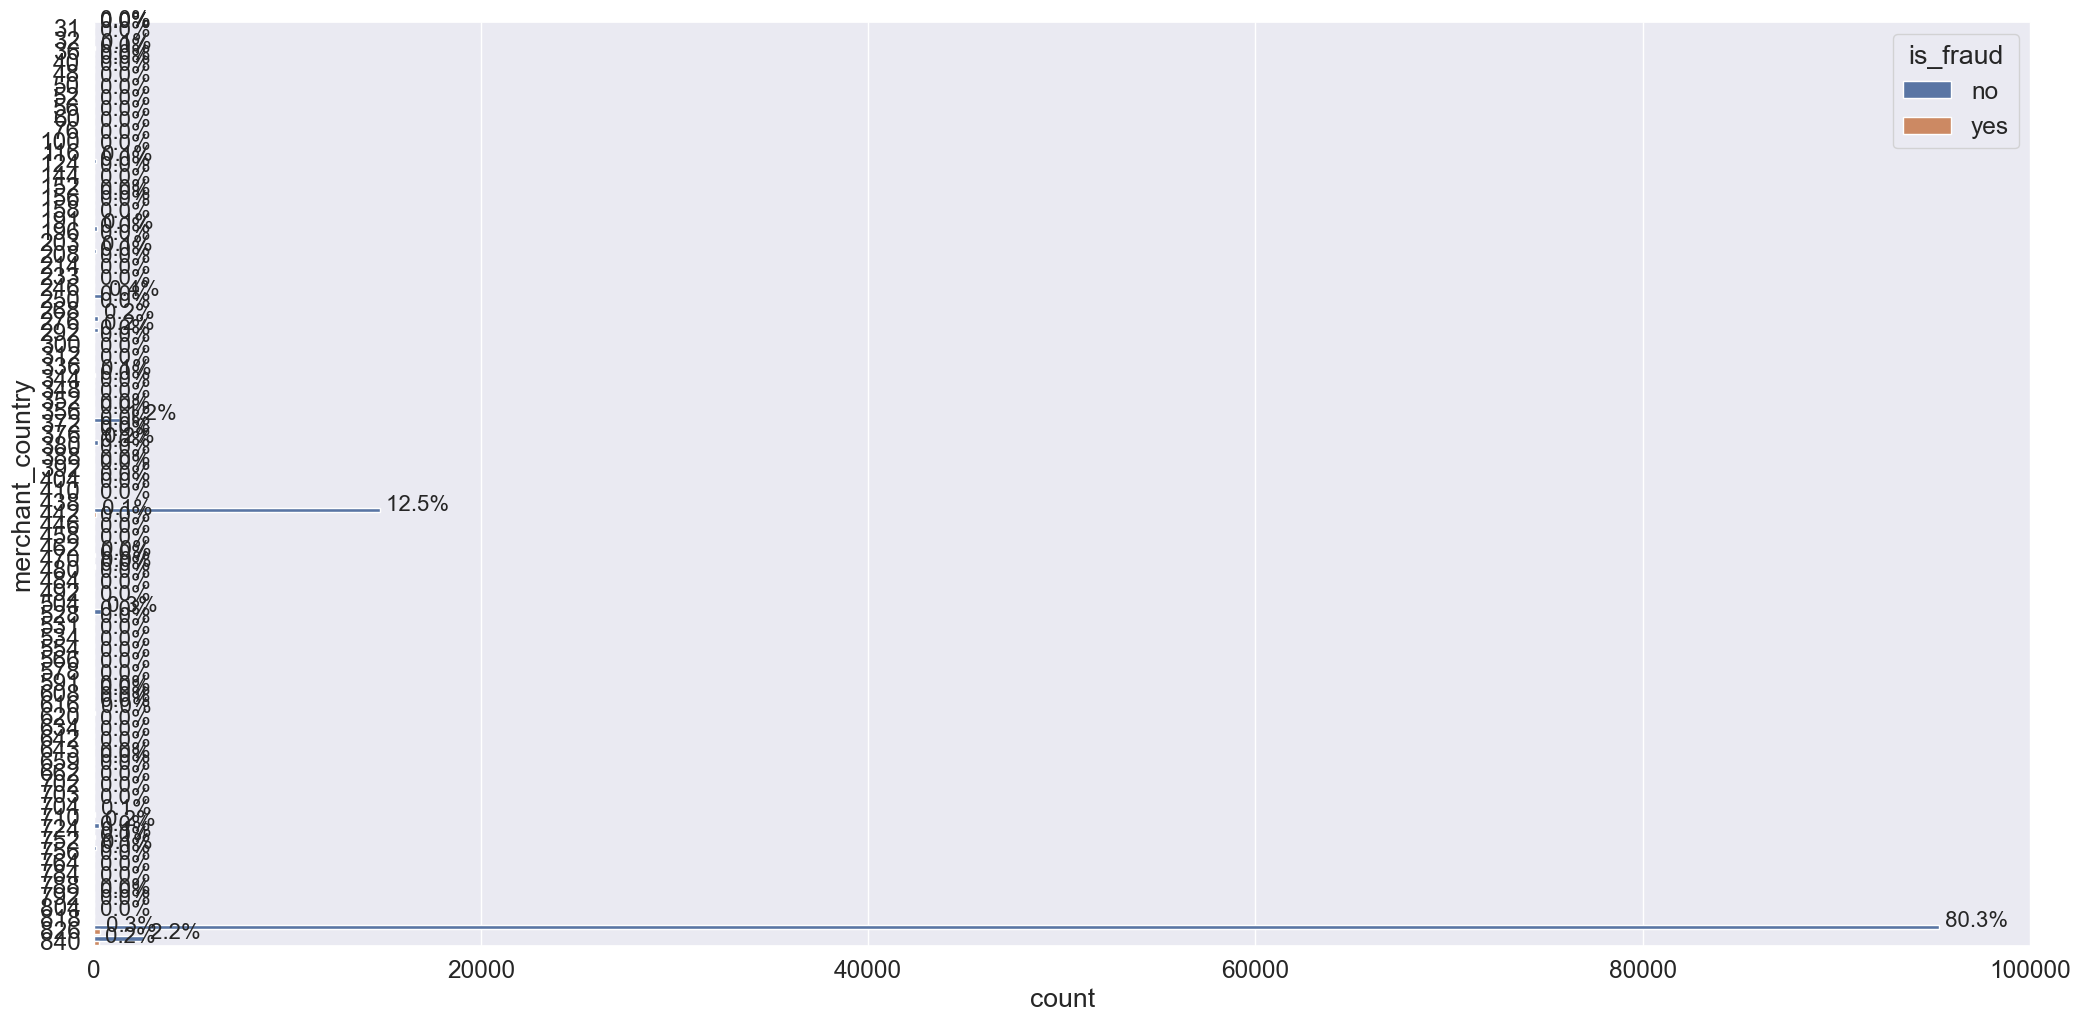

In [40]:
ax = sns.countplot(y='merchant_country', hue='is_fraud', data=df1)

total = df1['merchant_country'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## Most fraud happens at pos entry mode at 1 and 81

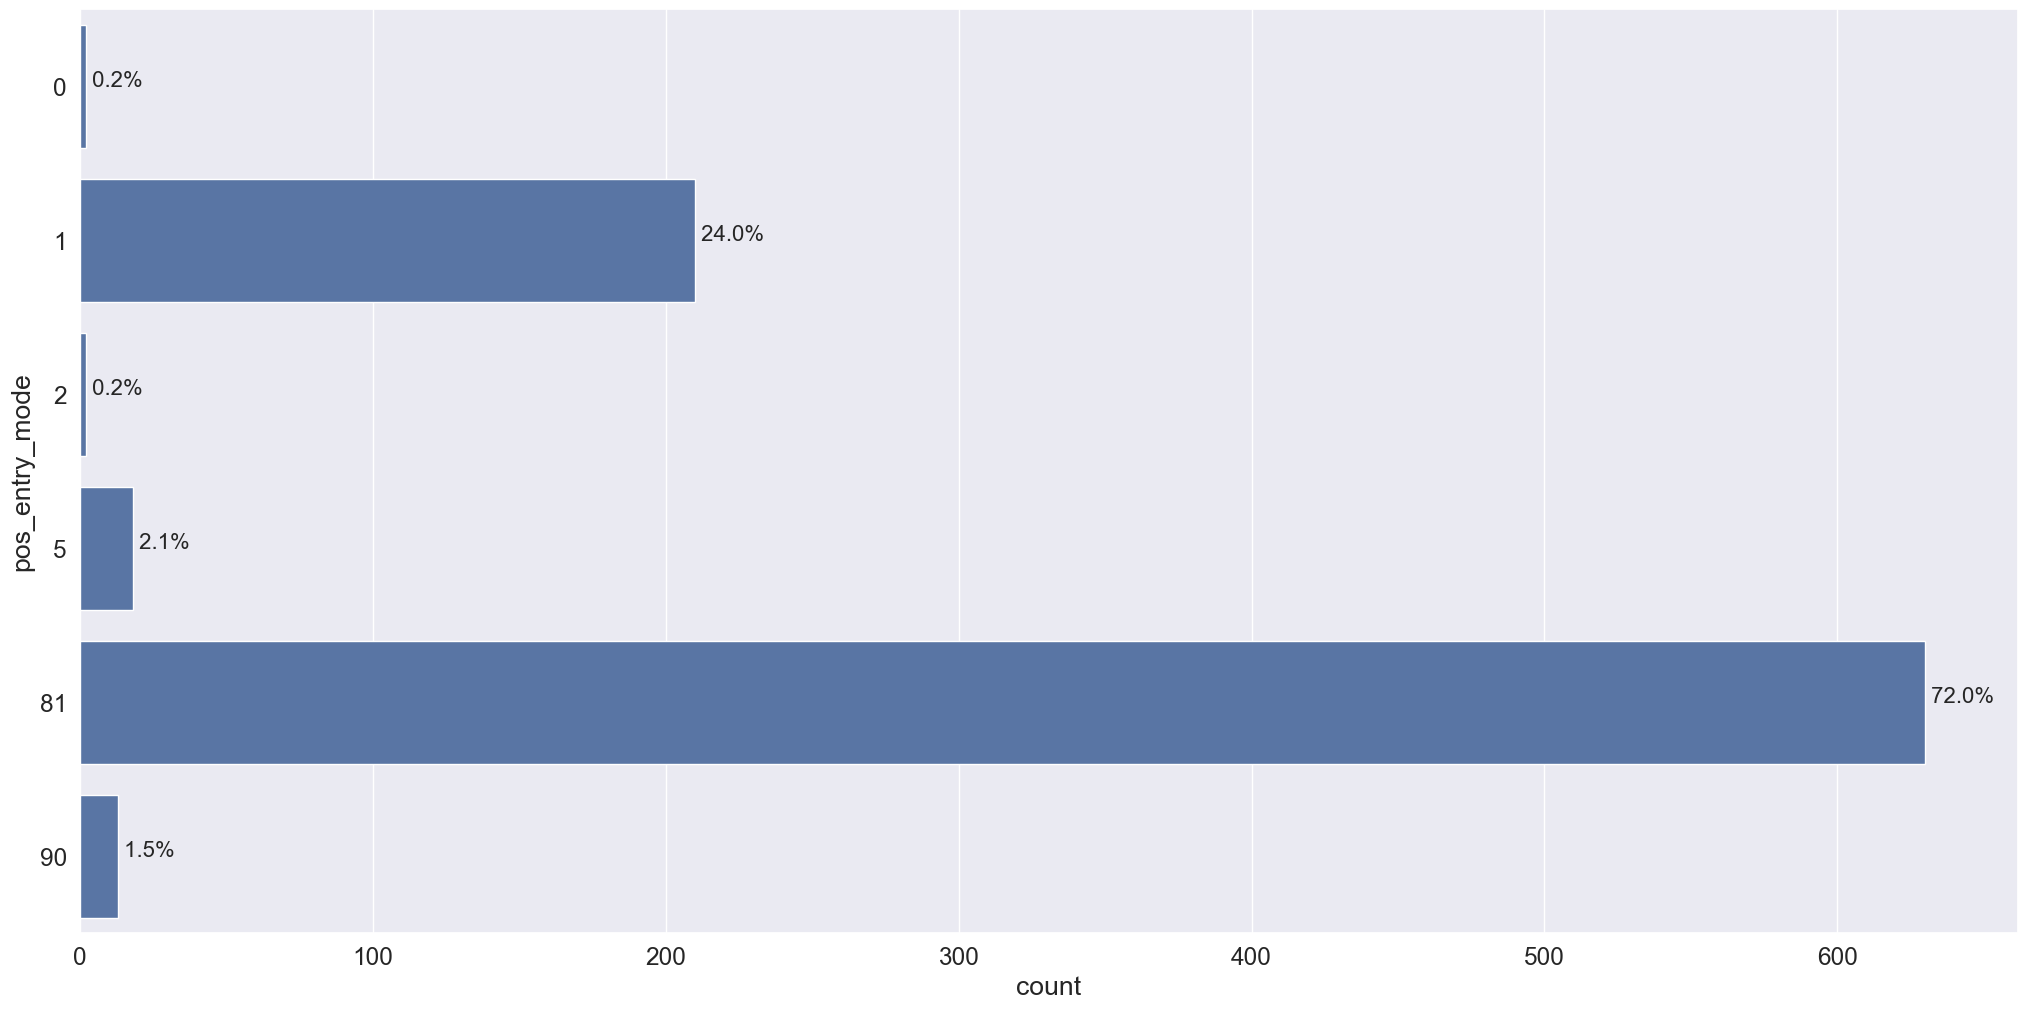

In [41]:
aux1 = df1[df1['is_fraud'] == 'yes']
ax = sns.countplot(y='pos_entry_mode', data=aux1)

total = aux1['pos_entry_mode'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

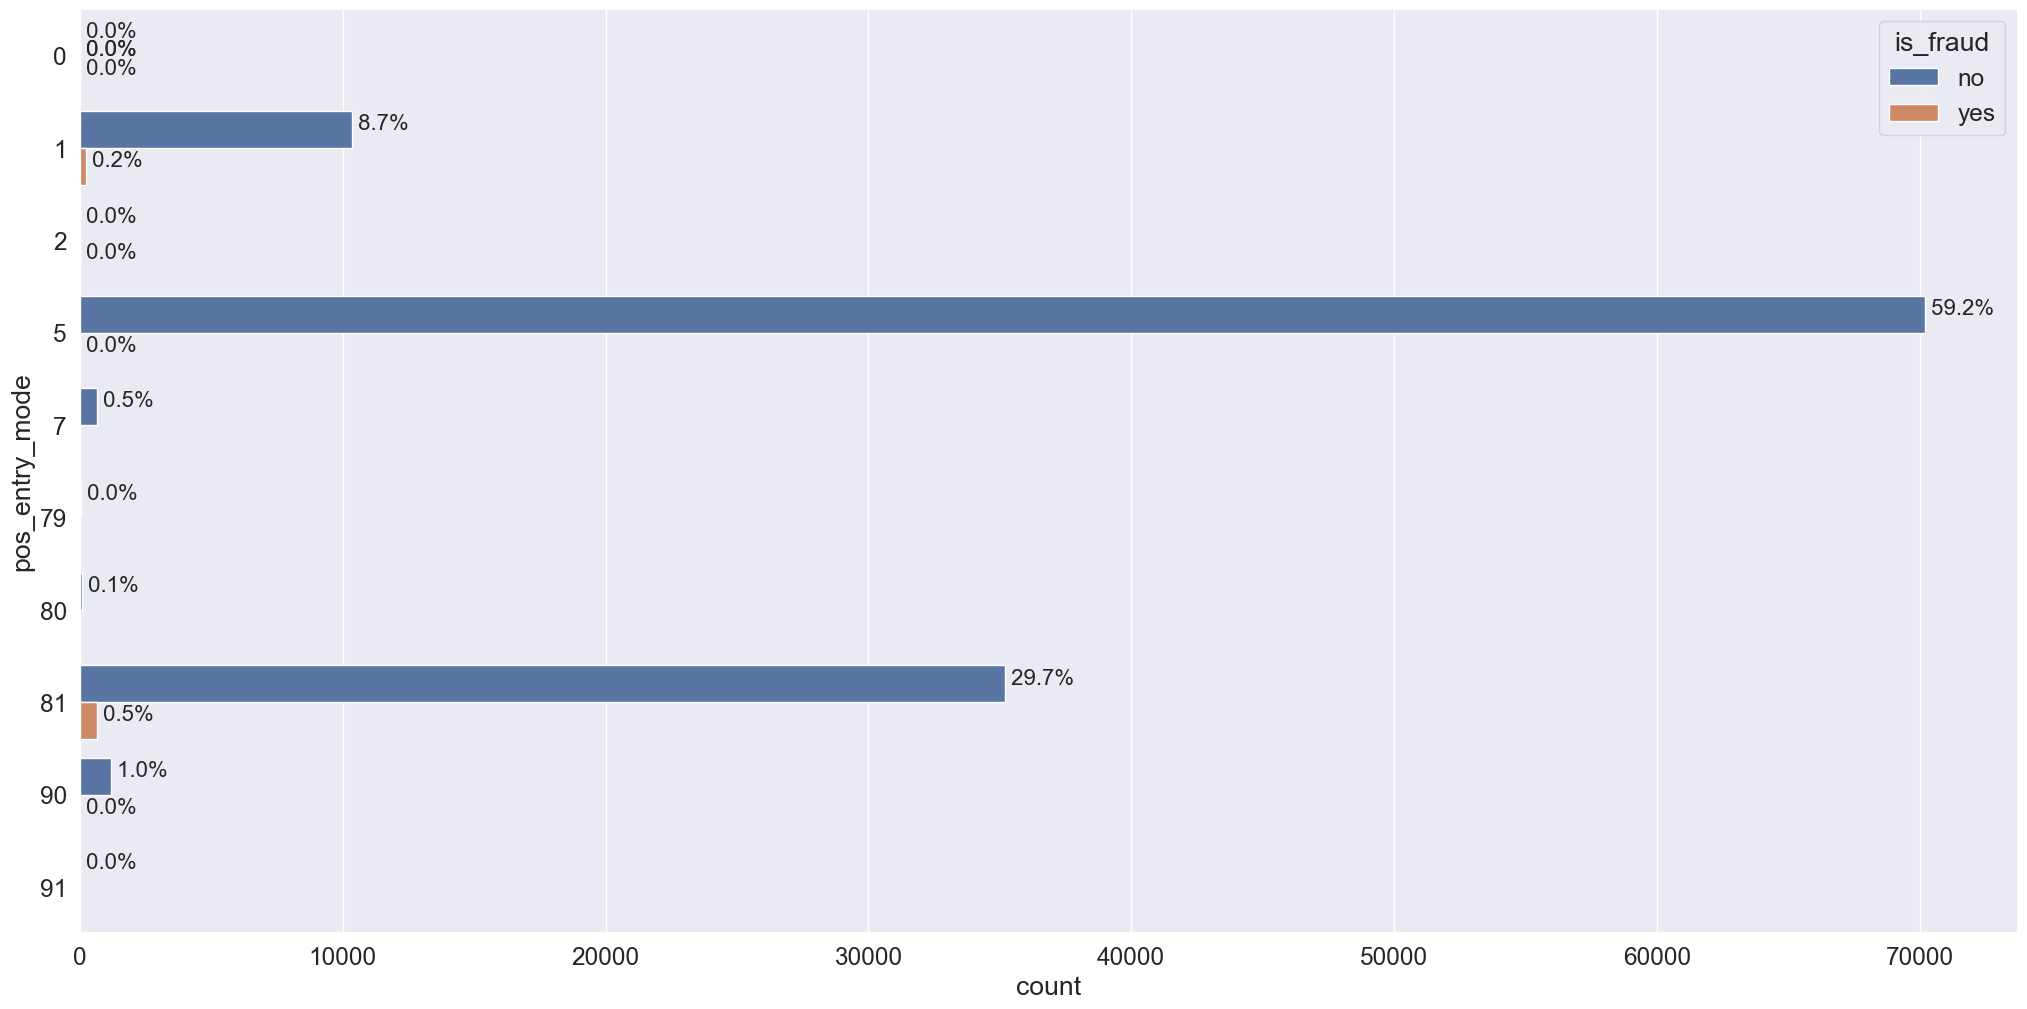

In [42]:
ax = sns.countplot(y='pos_entry_mode', hue='is_fraud', data=df1)

total = df1['pos_entry_mode'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

## 3.3 Multivariaty Analysis

### 3.3.1 Numerical Analysis

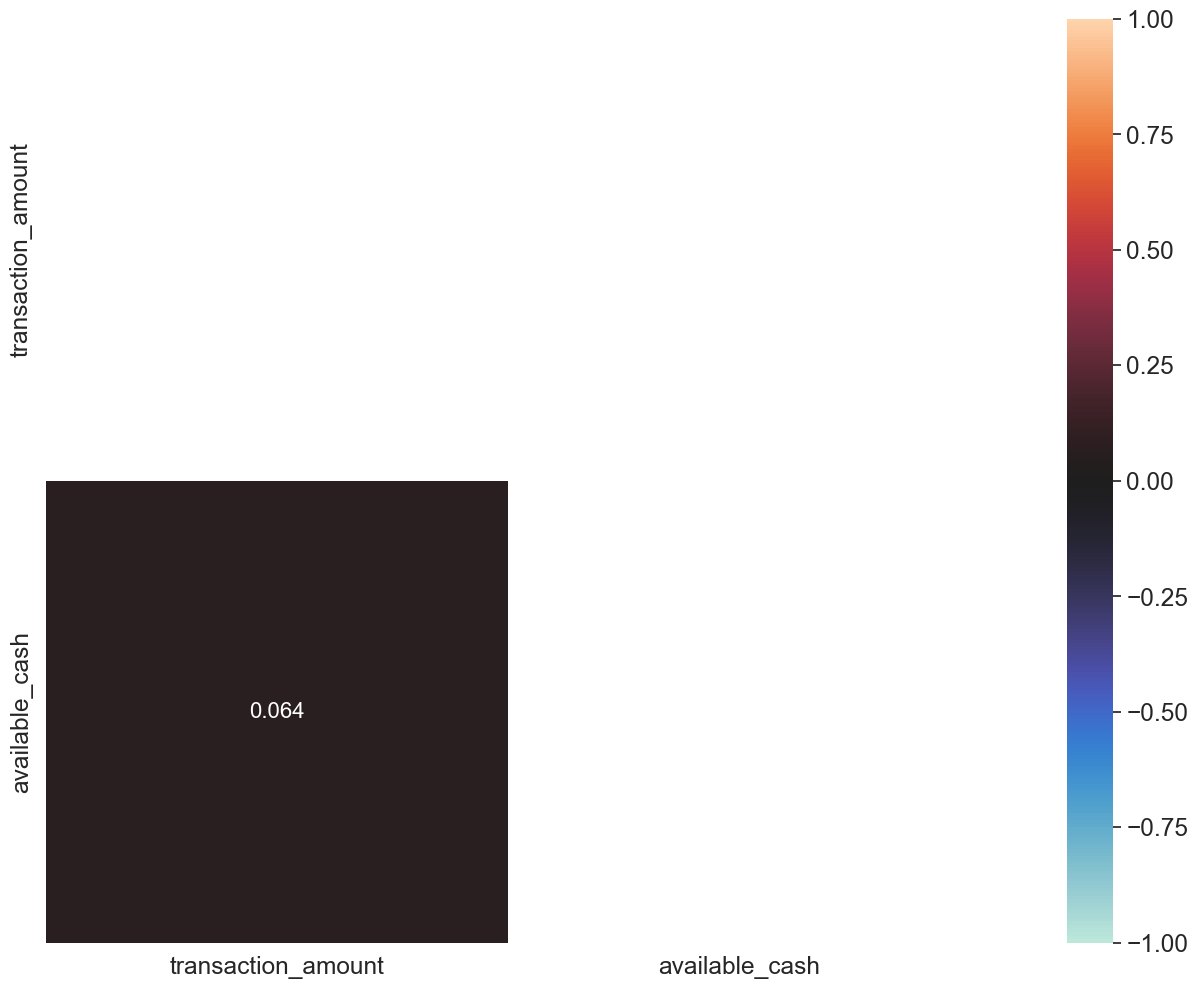

In [43]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 3.3.2 Categorical Variables

In [44]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

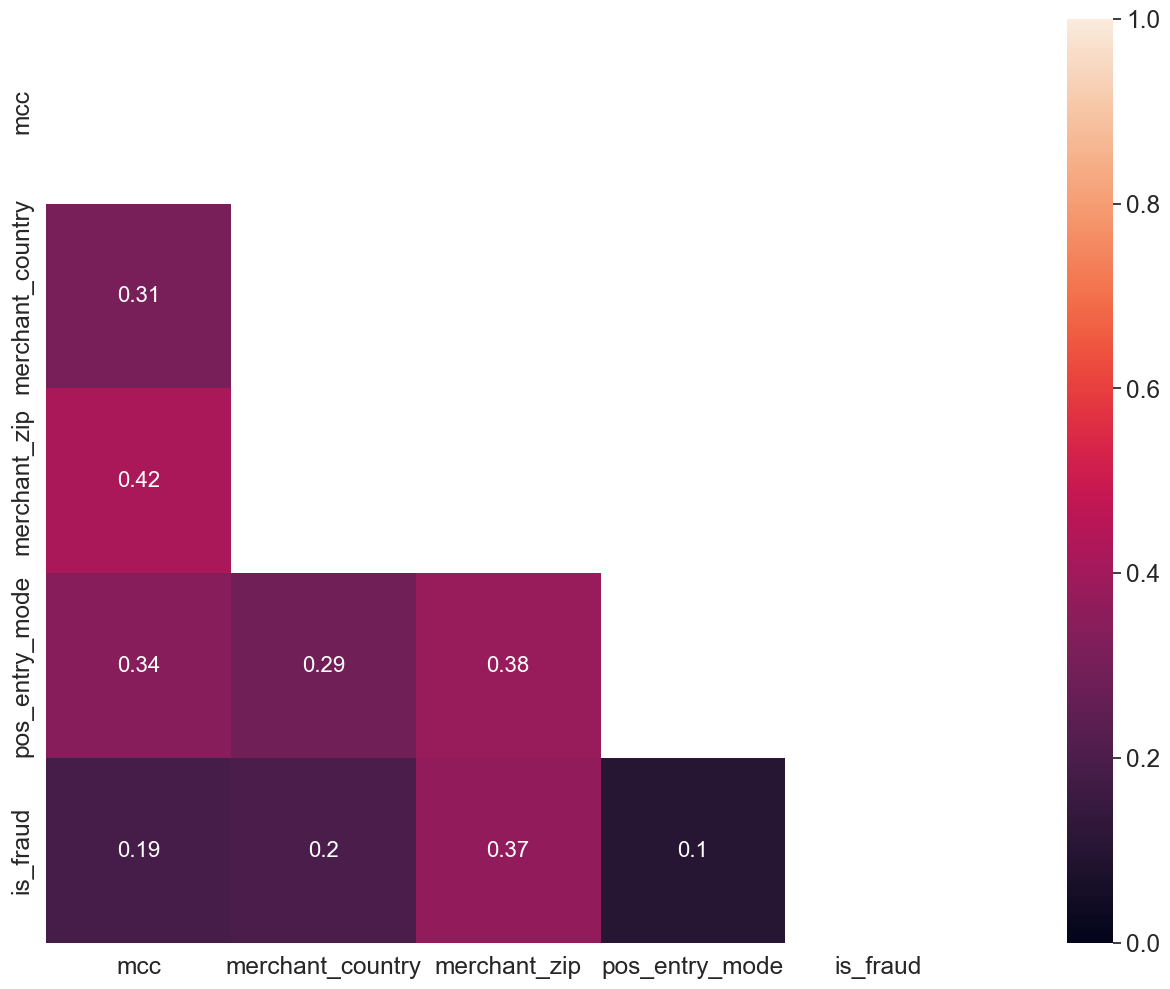

In [45]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 4.0 Data Preparation

In [46]:
df2 = df1.copy()

In [47]:
df2.columns

Index(['transaction_time', 'event_id', 'account_number', 'merchant_id', 'mcc',
       'merchant_country', 'merchant_zip', 'pos_entry_mode',
       'transaction_amount', 'available_cash', 'reported_time', 'is_fraud'],
      dtype='object')

## 4.1 Spliting into Train, Valid and Test

In [48]:
X = df2.drop(columns=['is_fraud', 'reported_time', 'transaction_time', 'event_id', 
                      'account_number', 'merchant_id','mcc','merchant_zip'], axis=1)
y = df2['is_fraud'].map({'yes': 1, 'no': 0})

In [49]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [50]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

In [51]:
X_train.columns

Index(['merchant_country', 'pos_entry_mode', 'transaction_amount',
       'available_cash'],
      dtype='object')

## 4.2 One Hot Encoder

In [52]:
ohe = OneHotEncoder(cols=['pos_entry_mode', 'merchant_country'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

## 4.3 Rescaling

In [53]:
num_columns = ['transaction_amount', 'available_cash']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

# 5.0 Feature Selection

In [54]:
X_params.head()

,merchant_country_826.0,merchant_country_442.0,merchant_country_372.0,merchant_country_124.0,merchant_country_616.0,merchant_country_840.0,merchant_country_292.0,merchant_country_528.0,merchant_country_710.0,merchant_country_250.0,merchant_country_470.0,merchant_country_40.0,merchant_country_724.0,merchant_country_392.0,merchant_country_344.0,merchant_country_591.0,merchant_country_702.0,merchant_country_208.0,merchant_country_380.0,merchant_country_300.0,merchant_country_480.0,merchant_country_788.0,merchant_country_276.0,merchant_country_156.0,merchant_country_554.0,merchant_country_792.0,merchant_country_246.0,merchant_country_643.0,merchant_country_36.0,merchant_country_196.0,merchant_country_620.0,merchant_country_756.0,merchant_country_752.0,merchant_country_203.0,merchant_country_76.0,merchant_country_534.0,merchant_country_52.0,merchant_country_56.0,merchant_country_356.0,merchant_country_312.0,merchant_country_662.0,merchant_country_578.0,merchant_country_348.0,merchant_country_818.0,merchant_country_446.0,merchant_country_659.0,merchant_country_492.0,merchant_country_784.0,merchant_country_608.0,merchant_country_484.0,merchant_country_352.0,merchant_country_804.0,merchant_country_144.0,merchant_country_462.0,merchant_country_191.0,merchant_country_764.0,merchant_country_438.0,merchant_country_31.0,merchant_country_214.0,merchant_country_376.0,merchant_country_410.0,merchant_country_158.0,merchant_country_388.0,merchant_country_703.0,merchant_country_504.0,merchant_country_233.0,merchant_country_458.0,merchant_country_100.0,merchant_country_566.0,merchant_country_634.0,merchant_country_32.0,merchant_country_531.0,merchant_country_60.0,merchant_country_50.0,merchant_country_404.0,merchant_country_268.0,merchant_country_704.0,merchant_country_48.0,merchant_country_642.0,merchant_country_116.0,merchant_country_336.0,pos_entry_mode_5.0,pos_entry_mode_81.0,pos_entry_mode_1.0,pos_entry_mode_90.0,pos_entry_mode_80.0,pos_entry_mode_0.0,pos_entry_mode_7.0,pos_entry_mode_79.0,pos_entry_mode_91.0,pos_entry_mode_2.0,transaction_amount,available_cash
108044,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.004519,0.444444
62411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000378,0.444444
41017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000674,0.611111
4404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.001434,0.000000
69802,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.000111,0.000000


In [55]:
# ## Remove variables with few values
# # Define a threshold for the minimum number of values
# threshold = 10 

# # Find columns that have fewer than the threshold number of 1s
# low_variance_cols = [col for col in df.columns if df[col].sum() < threshold]




In [56]:
X_train.var()

merchant_country_826.0    0.156070
merchant_country_442.0    0.109954
merchant_country_840.0    0.023638
merchant_country_380.0    0.002011
merchant_country_724.0    0.002497
merchant_country_52.0     0.000132
merchant_country_752.0    0.000855
merchant_country_300.0    0.000290
merchant_country_372.0    0.011908
merchant_country_470.0    0.000408
merchant_country_196.0    0.001552
merchant_country_292.0    0.001815
merchant_country_528.0    0.003439
merchant_country_246.0    0.000382
merchant_country_392.0    0.000237
merchant_country_124.0    0.001158
merchant_country_208.0    0.001145
merchant_country_50.0     0.000013
merchant_country_710.0    0.000685
merchant_country_36.0     0.000711
merchant_country_484.0    0.000356
merchant_country_756.0    0.001053
merchant_country_76.0     0.000211
merchant_country_554.0    0.000277
merchant_country_616.0    0.000145
merchant_country_659.0    0.000092
merchant_country_662.0    0.000053
merchant_country_388.0    0.000092
merchant_country_276

## 5.1 Boruta

In [57]:
X_boruta = X_params.values
y_boruta = y_temp.values.ravel()

In [58]:
boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
boruta.fit(X_boruta, y_boruta)

BorutaPy(estimator=RandomForestClassifier(n_estimators=14,
                                          random_state=RandomState(MT19937) at 0x106361440),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x106361440)

### 5.1.1 Best Features

In [59]:
cols_selected_boruta = boruta.support_.tolist()

In [60]:
columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [61]:
columns_selected

['transaction_amount']

In [62]:
# only transaction amount is selected.

### Use PCA to do dimention reduction

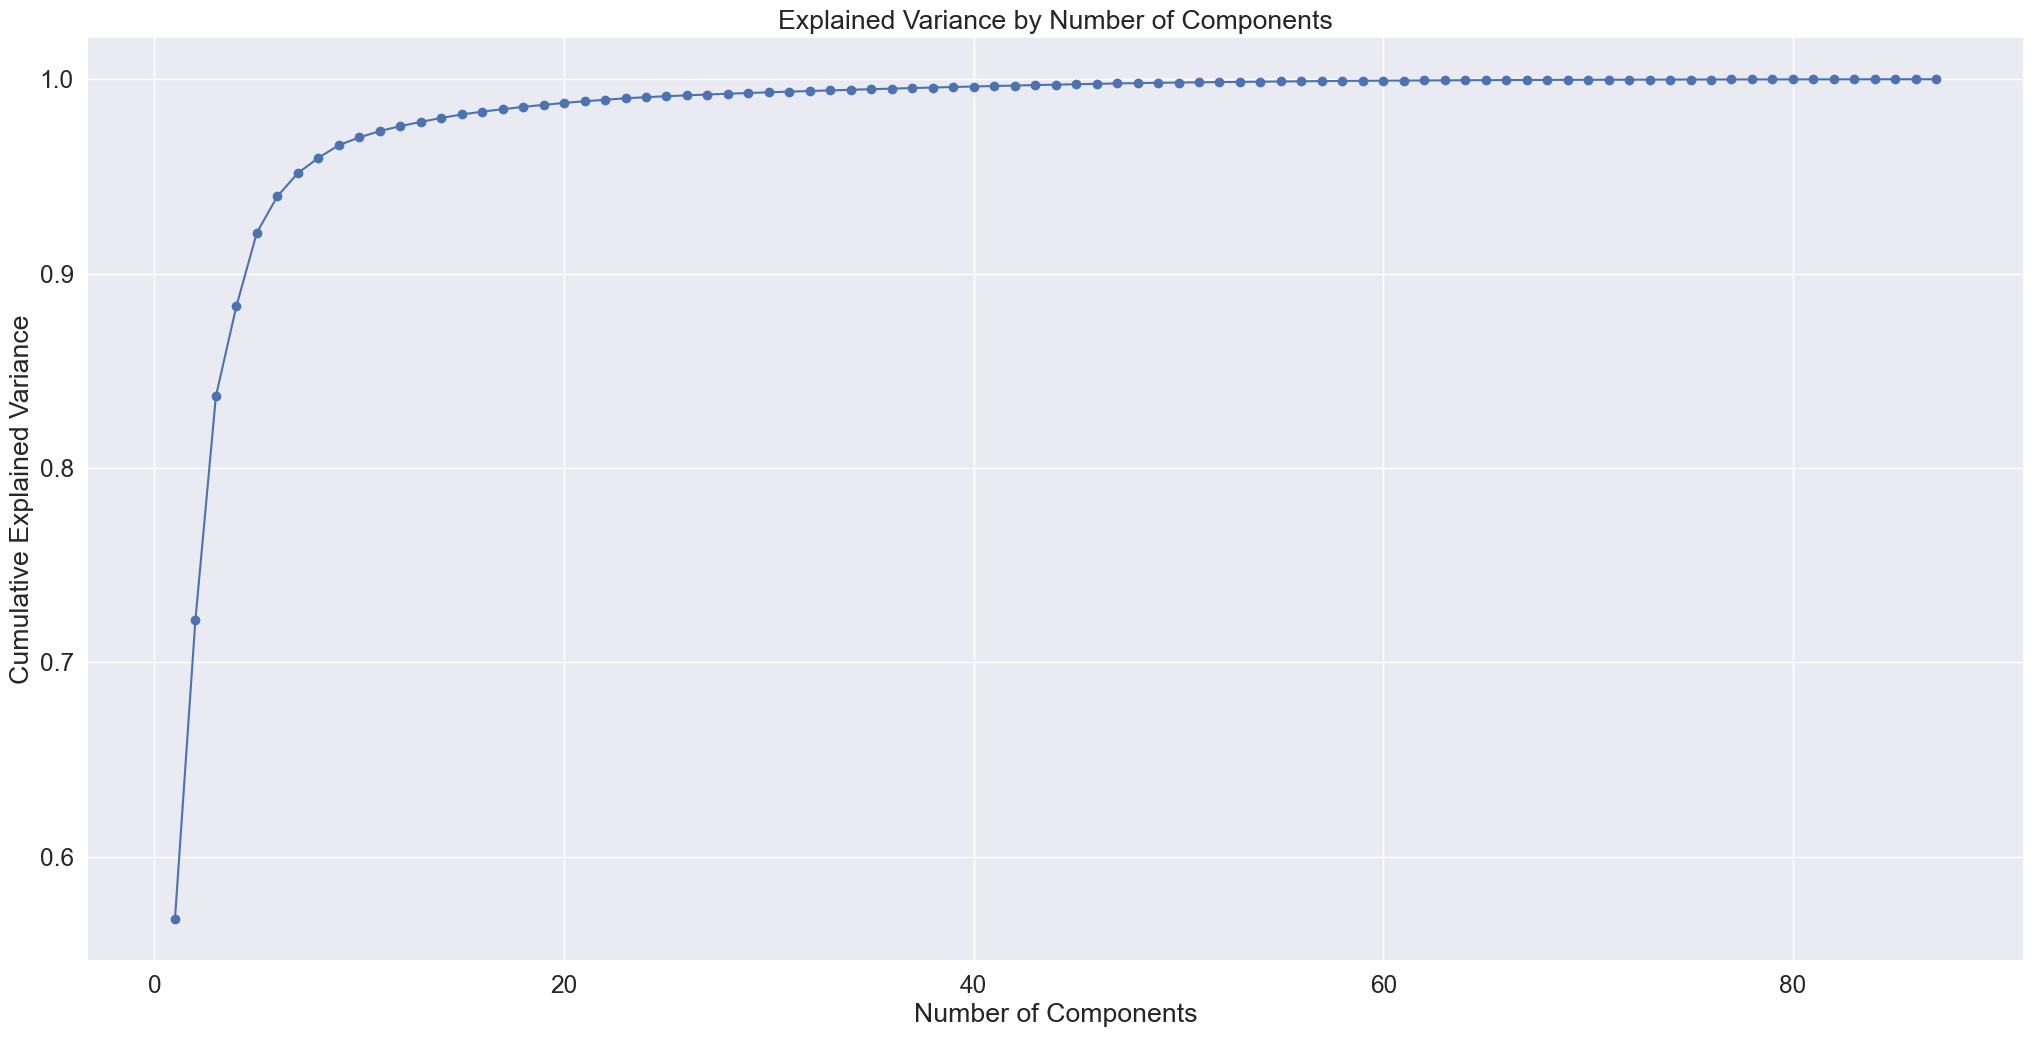

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Perform PCA
pca = PCA()
pca.fit(X_train)

# Plot the explained variance to use the elbow method
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [64]:
# Assuming the elbow point is found at 20 components
n_components = 20
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

X_params_pca = pca.fit_transform(X_params)
X_test_pca = pca.transform(X_test)

In [65]:
pd.DataFrame(X_train_pca).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.556648,-0.126548,-0.013435,-0.053247,0.127688,0.008956,-0.000952,-0.012061,-0.000385,0.000662,-0.000530,-0.001399,-0.001014,0.002060,0.001158,-0.000938,-0.000545,-0.000481,-0.000596,-0.000805
1,1.381105,-0.501178,0.208619,-0.302993,0.268984,-0.011540,0.014146,-0.027257,0.002147,0.003248,-0.000344,0.000172,-0.000472,0.002914,0.001484,-0.001310,-0.001142,-0.001237,-0.000509,-0.000906
2,-0.553473,-0.121881,-0.011947,-0.019131,0.022781,-0.001454,-0.005030,-0.008381,-0.000726,-0.000092,0.000284,-0.001127,-0.000777,0.000962,0.000487,-0.000756,-0.000178,-0.000120,-0.000464,-0.000649
3,1.099755,-0.030466,0.059540,0.977410,0.205750,-0.264416,-0.428014,-0.102774,0.136246,0.002279,0.010355,0.005285,0.005866,-0.006442,-0.003151,-0.001027,0.000803,0.001067,0.005190,-0.002833
4,-0.553473,-0.121882,-0.011947,-0.019131,0.022780,-0.001455,-0.005030,-0.008382,-0.000725,-0.000093,0.000286,-0.001126,-0.000780,0.000964,0.000488,-0.000754,-0.000178,-0.000120,-0.000463,-0.000649


# 6.0 Machine Learning Modeling

In [66]:
X_train_cs = X_train_pca
X_valid_cs = X_valid_pca

X_test_cs = X_test_pca

X_params_cs =pd.DataFrame(X_params_pca)

## 6.1 Baseline

In [67]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [68]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### 6.1.1 Classification Report

In [69]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18840
           1       0.00      0.00      0.00       140

    accuracy                           0.99     18980
   macro avg       0.50      0.50      0.50     18980
weighted avg       0.99      0.99      0.99     18980



### 6.1.2 Cross Validation

In [70]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 6.2 Logistic Regression

In [71]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [72]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5,0.0,0.0,0.0,0.0


### 6.2.1 Classification Report

In [73]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18840
           1       0.00      0.00      0.00       140

    accuracy                           0.99     18980
   macro avg       0.50      0.50      0.50     18980
weighted avg       0.99      0.99      0.99     18980



### 6.2.2 Cross Validation

In [74]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_params_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 6.3 K Nearest Neighbors

In [75]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [76]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.571,0.426,0.143,0.214,0.211


### 6.3.1 Classification Report

In [77]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18840
           1       0.43      0.14      0.21       140

    accuracy                           0.99     18980
   macro avg       0.71      0.57      0.61     18980
weighted avg       0.99      0.99      0.99     18980



### 6.3.2 Cross Validation

In [78]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), 
                       X_params_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.594 +/- 0.01,0.561 +/- 0.07,0.19 +/- 0.019,0.284 +/- 0.03,0.281 +/- 0.03


## 6.4 Support Vector Machine

In [79]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [80]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


### 6.4.1 Classification Report

In [81]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18840
           1       0.00      0.00      0.00       140

    accuracy                           0.99     18980
   macro avg       0.50      0.50      0.50     18980
weighted avg       0.99      0.99      0.99     18980



### 6.4.2 Cross Validation

In [82]:
svm_cv = ml_cv_results('SVM', SVC(), X_params_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 6.5 Random Forest

In [83]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [84]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.657,0.141,0.329,0.197,0.189


### 6.5.1 Classification Report

In [85]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18840
           1       0.14      0.33      0.20       140

    accuracy                           0.98     18980
   macro avg       0.57      0.66      0.59     18980
weighted avg       0.99      0.98      0.98     18980



### 6.5.2 Cross Validation

In [86]:
rf_cv = ml_cv_results('Random Forest', 
                      RandomForestClassifier(), 
                      X_params_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.626 +/- 0.019,0.44 +/- 0.049,0.254 +/- 0.037,0.322 +/- 0.042,0.318 +/- 0.042


## 6.6 XGBoost

In [87]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [88]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.549,0.412,0.1,0.161,0.158


### 6.6.1 Classification Report

In [89]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18840
           1       0.41      0.10      0.16       140

    accuracy                           0.99     18980
   macro avg       0.70      0.55      0.58     18980
weighted avg       0.99      0.99      0.99     18980



### 6.6.2 Cross Validation

In [90]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_params_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.544 +/- 0.015,0.56 +/- 0.129,0.089 +/- 0.029,0.153 +/- 0.048,0.151 +/- 0.048


## 6.7 LightGBM

In [175]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

[LightGBM] [Info] Number of positive: 560, number of negative: 75356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 75916, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007377 -> initscore=-4.902042
[LightGBM] [Info] Start training from score -4.902042


In [176]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.588,0.417,0.179,0.25,0.247


In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_valid, y_pred)

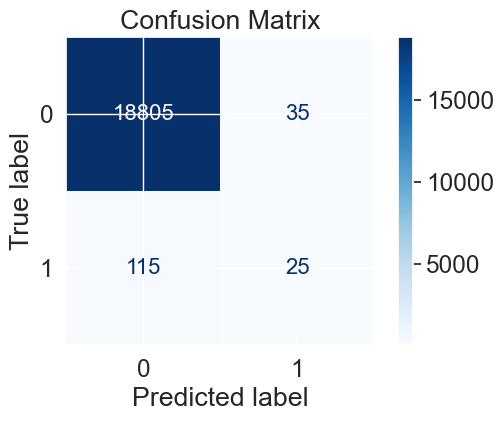

In [182]:

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### 6.7.1 Classification Report

In [93]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18840
           1       0.42      0.18      0.25       140

    accuracy                           0.99     18980
   macro avg       0.71      0.59      0.62     18980
weighted avg       0.99      0.99      0.99     18980



### 6.7.2 Cross Validation

In [94]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(), 
                            X_params_cs, y_temp)
lightgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 560, number of negative: 75356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 75916, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007377 -> initscore=-4.902042
[LightGBM] [Info] Start training from score -4.902042
Fold K=2
[LightGBM] [Info] Number of positive: 560, number of negative: 75357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 75917, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007376 -> initscore=-4.902055
[LightGBM] [Info] Start training from score -4.90205

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.56 +/- 0.018,0.466 +/- 0.148,0.121 +/- 0.036,0.191 +/- 0.055,0.189 +/- 0.056


## 6.8 Comparing Model's Performance

### 6.8.1 Single Performance

In [95]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
Logistic Regression,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
XGBoost,0.549,0.412,0.100,0.161,0.158
Random Forest,0.657,0.141,0.329,0.197,0.189
K Nearest Neighbors,0.571,0.426,0.143,0.214,0.211
LightGBM,0.588,0.417,0.179,0.250,0.247


### 6.8.2 Cross Validation Performance

In [96]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
SVM,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
XGBoost,0.544 +/- 0.015,0.56 +/- 0.129,0.089 +/- 0.029,0.153 +/- 0.048,0.151 +/- 0.048
LightGDM,0.56 +/- 0.018,0.466 +/- 0.148,0.121 +/- 0.036,0.191 +/- 0.055,0.189 +/- 0.056
K Nearest Neighbors,0.594 +/- 0.01,0.561 +/- 0.07,0.19 +/- 0.019,0.284 +/- 0.03,0.281 +/- 0.03
Random Forest,0.626 +/- 0.019,0.44 +/- 0.049,0.254 +/- 0.037,0.322 +/- 0.042,0.318 +/- 0.042


# 7.0 Hyperparameter Fine Tuning

In [97]:
f1 = make_scorer(f1_score)

In [131]:
rf = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [132]:
X_params_cs.shape

(94896, 20)

In [133]:
# Randomized Search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_params_cs, y_temp)

# Best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_rf = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 40, 'bootstrap': True}


In [134]:

# Predict on the test set
y_test_pred = best_rf.predict(X_test_cs)



In [135]:
rf_ft__results = ml_scores('RF-finetune', y_test, y_test_pred)
rf_ft__results

,Balanced Accuracy,Precision,Recall,F1,Kappa
RF-finetune,0.681,0.151,0.377,0.216,0.208


# 8.0 Conclusions 

## 8.1 Final Model

In [137]:
# Get the best hyperparameters
best_params = random_search.best_params_
# Fit the final model with the best hyperparameters on the entire training dataset
final_rf = RandomForestClassifier(**best_params, random_state=42)
final_rf.fit(X_params_cs, y_temp)



RandomForestClassifier(max_depth=40, min_samples_leaf=2, n_estimators=500,
                       random_state=42)

### 8.1.1 Unseen Data Score

In [146]:
y_pred_proba = final_rf.predict_proba(X_test_cs)

In [147]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.554,0.613,0.109,0.184,0.183


### What is the model's Precision and Accuracy?

In [148]:
print('For unseen data, the values of balanced accuracy is equal %.2f and precision is equal %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

For unseen data, the values of balanced accuracy is equal 0.55 and precision is equal 0.61.


### How reliable is the model in classifying transactions as legitimate or fraudulent?

In [149]:
print('The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.')

The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.


In [150]:
y_pred_proba

array([[9.99705882e-01, 2.94117647e-04],
       [9.99914890e-01, 8.51100542e-05],
       [9.99857143e-01, 1.42857143e-04],
       ...,
       [9.99549370e-01, 4.50630209e-04],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]])

# Compare to ramdom selecting transactions, select transactions according to predicted risks from the model

In [157]:
y_test = pd.DataFrame(y_test)

[  0.          29.56338913  29.57704175 ...  99.92081479  99.98634738
 100.        ]
[[       nan]
 [0.05541701]
 [0.05539143]
 ...
 [0.94004482]
 [0.9394287 ]
 [0.93930044]]


[Text(0, -0.2, '-0.20%'),
 Text(0, 0.0, '0.00%'),
 Text(0, 0.2, '0.20%'),
 Text(0, 0.4000000000000001, '0.40%'),
 Text(0, 0.6000000000000001, '0.60%'),
 Text(0, 0.8, '0.80%'),
 Text(0, 1.0000000000000002, '1.00%'),
 Text(0, 1.2000000000000002, '1.20%'),
 Text(0, 1.4000000000000001, '1.40%')]

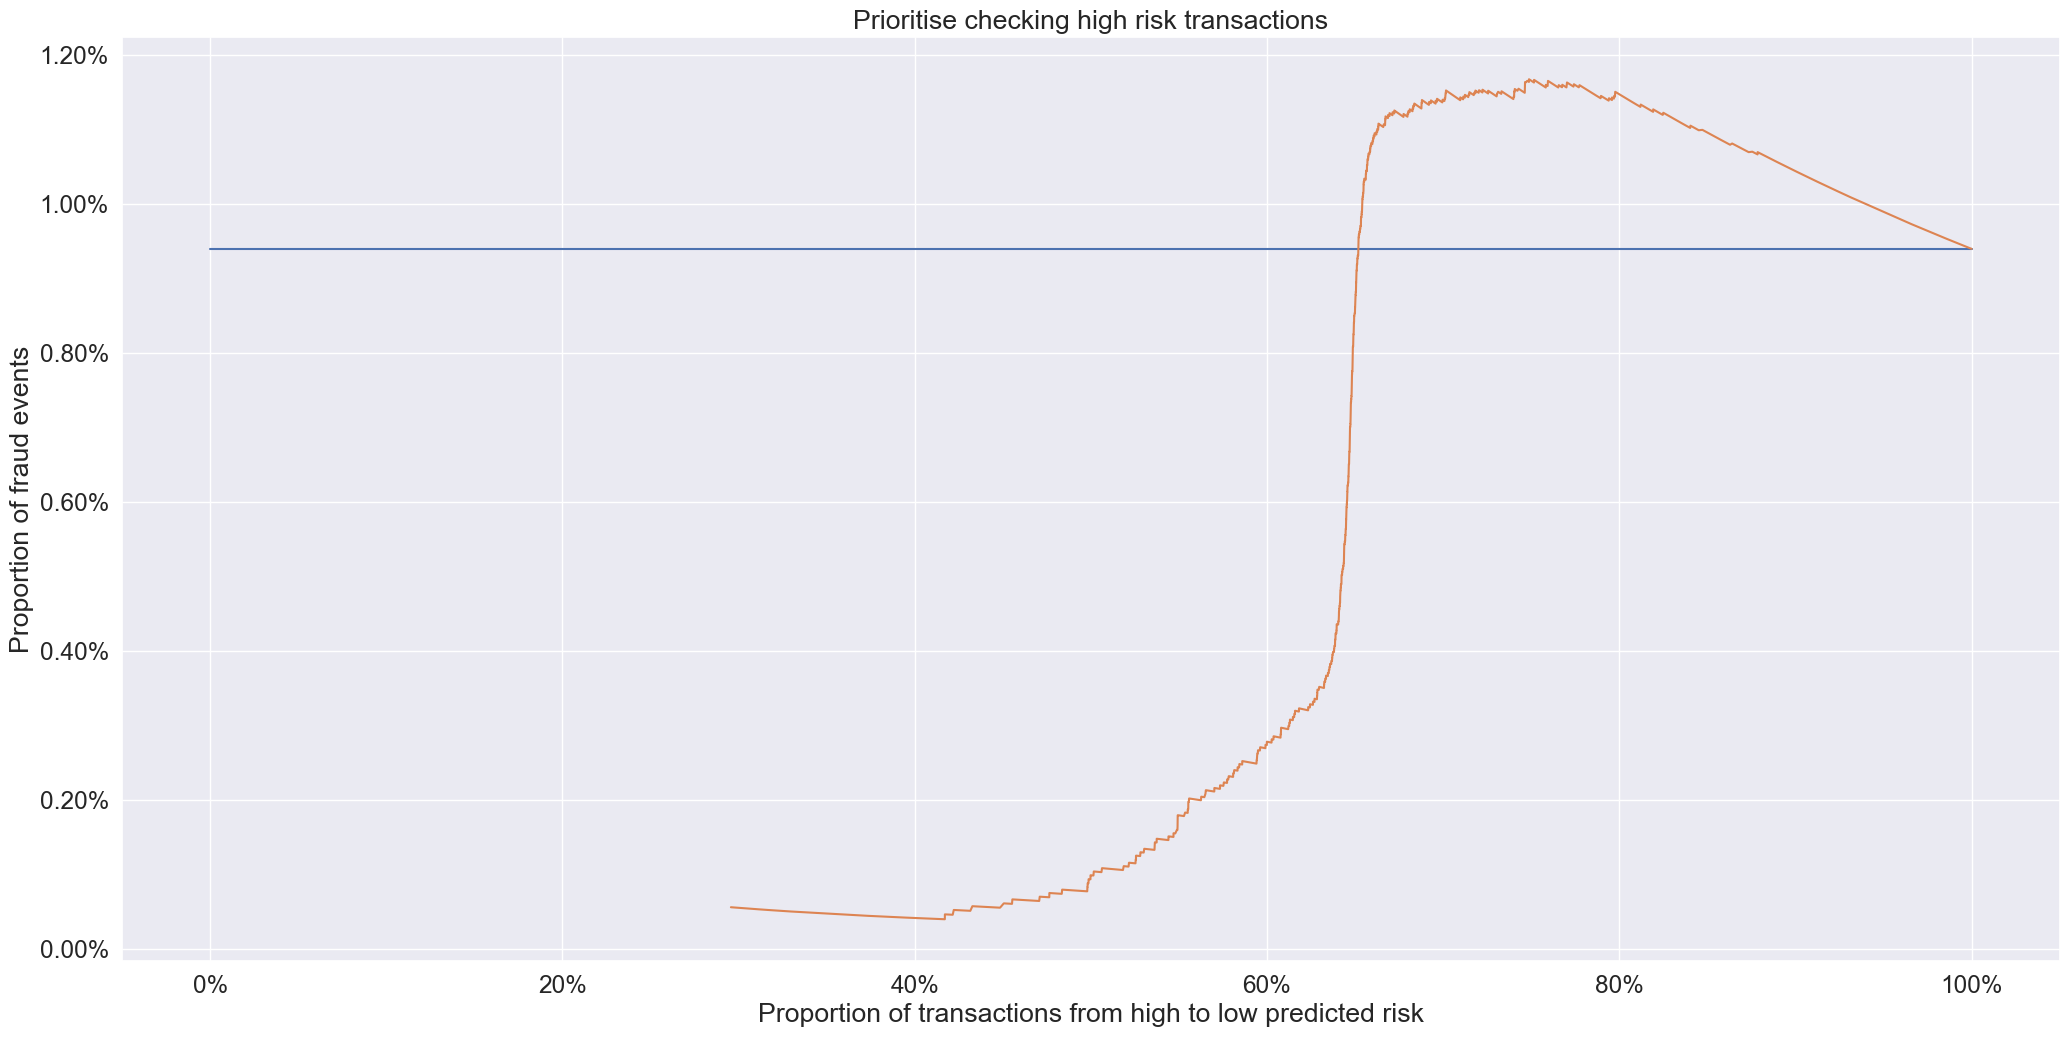

In [174]:

xs = []
ys = []
for threshold in sorted(np.unique(y_pred_proba), reverse=True):
    ind2 = y_pred_proba > threshold
    xs.append(np.sum(ind2))
    ys.append(np.sum(y_test[ind2]) / np.sum(ind2))
xs = np.array(xs) / np.max(xs) * 100
ys = np.array(ys) * 100
    
event_rate = ys[-1][0]
sns.lineplot(x=[0, 100], y=[event_rate, event_rate])

print(xs)  
print(ys)
ax = sns.lineplot(x=xs, y=ys.flatten())
ax.set(xlabel='Proportion of transactions from high to low predicted risk', ylabel='Proportion of fraud events', title='Prioritise checking high risk transactions')
x_value=['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
ax.set_xticklabels(x_value)
y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)
